Using device: cpu
Files already downloaded and verified


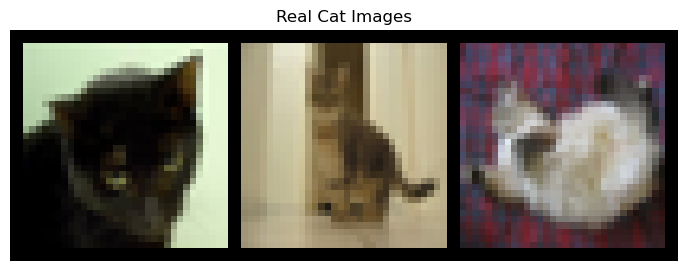

[Epoch 1/5] [Train Loss: -0.0711]
[Epoch 2/5] [Train Loss: -0.3430]
[Epoch 3/5] [Train Loss: -0.6857]
[Epoch 4/5] [Train Loss: -0.9143]
[Epoch 5/5] [Train Loss: -0.9855]


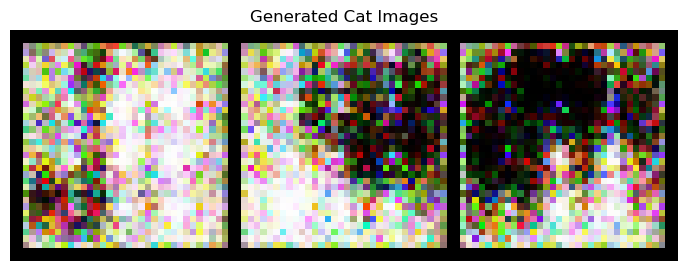

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt

# 1. GPU/CPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. 데이터셋 설정: CIFAR-10에서 고양이 클래스만 선택
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1] 범위로 정규화
])

# CIFAR-10 데이터셋 로드
cifar10 = datasets.CIFAR10(root='./data', download=True, transform=transform)
cat_class = 3  # CIFAR-10에서 고양이 클래스 레이블

# 고양이 클래스만 필터링
cat_indices = [i for i, data in enumerate(cifar10) if data[1] == cat_class]
cat_data = Subset(cifar10, cat_indices)

# 3. 고양이 데이터셋을 Train, Validation, Test로 분할
train_size = int(0.8 * len(cat_data))  # 80% 훈련
val_size = int(0.1 * len(cat_data))    # 10% 검증
test_size = len(cat_data) - train_size - val_size  # 나머지 10% 테스트

train_data, val_data, test_data = random_split(cat_data, [train_size, val_size, test_size])

# DataLoader 설정
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# 4. 생성자 정의
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # from (batch_size, latent_dim, 1, 1) to (batch_size, 512, 4, 4)
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # from (batch_size, 512, 4, 4) to (batch_size, 256, 8, 8)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # from (batch_size, 256, 8, 8) to (batch_size, 128, 16, 16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # from (batch_size, 128, 16, 16) to (batch_size, 3, 32, 32)
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # [-1, 1] 범위의 출력
        )
    
    def forward(self, z):
        return self.model(z)

# 5. 비판자 정의
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            # from (batch_size, 3, 32, 32) to (batch_size, 128, 16, 16)
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # from (batch_size, 128, 16, 16) to (batch_size, 256, 8, 8)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # from (batch_size, 256, 8, 8) to (batch_size, 512, 4, 4)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # from (batch_size, 512, 4, 4) to (batch_size, 1, 1, 1)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )
    
    def forward(self, img):
        return self.model(img).view(-1)

# 하이퍼파라미터 설정
latent_dim = 100
lr = 0.00005
n_epochs = 5
n_critic = 5
clip_value = 0.01  # 가중치 클리핑 범위

# 모델 초기화 (해당 장치로 전송)
generator = Generator(latent_dim).to(device)
critic = Critic().to(device)

# 최적화 함수 설정
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

# 6. 초기 고양이 이미지 3장 표시
def show_real_images():
    real_images, _ = next(iter(train_loader))
    real_images = real_images[:3]  # 처음 3장 선택
    real_images = (real_images * 0.5) + 0.5  # [-1, 1]에서 [0, 1]로 변환
    grid_img = vutils.make_grid(real_images, nrow=3)
    plt.figure(figsize=(9, 3))
    plt.title("Real Cat Images")
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_real_images()  # 학습 전 실제 이미지 표시

# 학습 루프
for epoch in range(n_epochs):
    train_loss_epoch = 0
    val_loss_epoch = 0

    # 7. Training Phase
    generator.train()
    critic.train()
    
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        
        # Critic 학습
        optimizer_C.zero_grad()
        
        # 실제 이미지에 대한 손실
        real_loss = critic(imgs).mean()
        
        # 가짜 이미지에 대한 손실
        z = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
        fake_imgs = generator(z).detach()
        fake_loss = critic(fake_imgs).mean()
        
        # Critic의 총 손실 = 실제 - 가짜
        critic_loss = -(real_loss - fake_loss)
        critic_loss.backward()
        optimizer_C.step()
        
        # 가중치 클리핑 적용
        for p in critic.parameters():
            p.data.clamp_(-clip_value, clip_value)
        
        train_loss_epoch += critic_loss.item()

        # n_critic 주기마다 Generator 학습
        if i % n_critic == 0:
            optimizer_G.zero_grad()
            
            # 생성된 이미지에 대한 Critic의 평가를 최대화
            gen_imgs = generator(z)
            generator_loss = -critic(gen_imgs).mean()
            generator_loss.backward()
            optimizer_G.step()

    # 에포크당 평균 훈련 손실 계산
    train_loss_epoch /= len(train_loader)

    # 학습 상태 출력
    print(f"[Epoch {epoch+1}/{n_epochs}] [Train Loss: {train_loss_epoch:.4f}]")

# 8. 학습 후 생성된 이미지 3장 표시
def show_generated_images():
    with torch.no_grad():
        sample_z = torch.randn(3, latent_dim, 1, 1).to(device)
        generated_imgs = generator(sample_z).cpu()
        generated_imgs = (generated_imgs * 0.5) + 0.5  # [-1, 1]에서 [0, 1]로 변환
        grid_img = vutils.make_grid(generated_imgs, nrow=3)
        plt.figure(figsize=(9, 3))
        plt.title("Generated Cat Images")
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

show_generated_images()  # 학습 후 생성된 이미지 표시
